In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import arviz as az
%matplotlib inline

In [7]:
df_data = pd.read_csv('data.csv')
df_data.value.describe()

count    7362.00000
mean        0.18005
std         0.22215
min         0.01060
25%         0.01680
50%         0.04225
75%         0.32382
max         0.74380
Name: value, dtype: float64

In [10]:
df_data.head()

,transactiondate,value
0,2018-01-10 00:01:11,0.0168
1,2018-01-10 00:01:57,0.0293
2,2018-01-10 00:02:12,0.0199
3,2018-01-10 00:02:16,0.0416
4,2018-01-10 00:03:08,0.0132


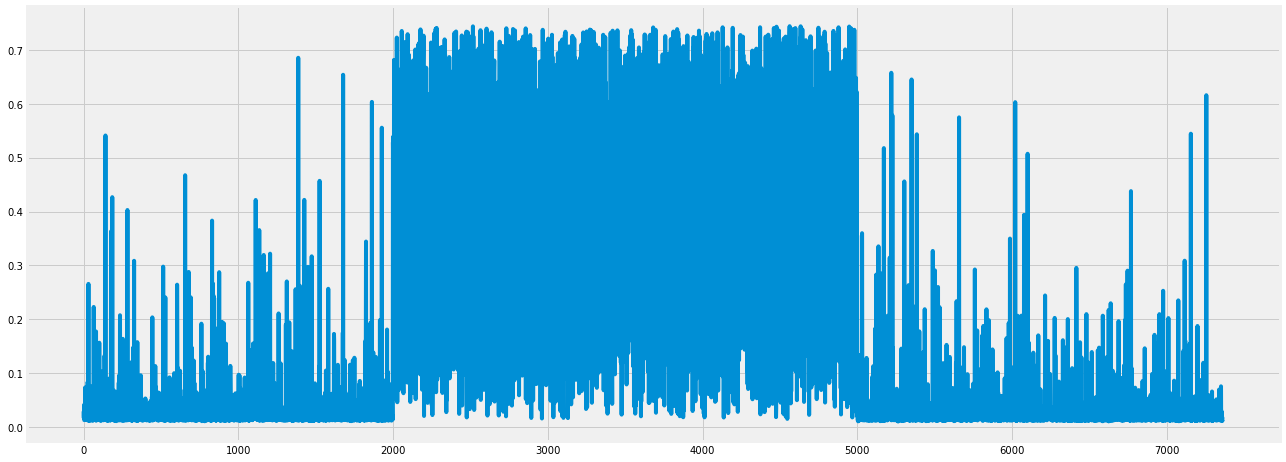

In [13]:
fig,axs = plt.subplots(1,1,figsize = (20,8))
axs.plot(df_data.value)
plt.show()


In [18]:
import numpy as np
import scipy.stats as stats
from scipy.stats import norm
import pymc3 as pm
import theano
from theano import tensor as T
from pymc3.math import switch
import matplotlib.pyplot as plt
T.sqrt

In [20]:
with pm.Model() as model: # context management
    mu_model = pm.Uniform('mu_model',0,1)
    sigma_model = pm.Uniform('sigma_model',0,T.sqrt(mu_model*(1- mu_model)))
    outage_prob = pm.Beta('outage_prob',mu = mu_model,sigma = sigma_model, observed = df_data.value)

In [22]:
with model:
  trace = pm.sample(1000,tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_model, mu_model]
Sampling 4 chains, 0 divergences: 100%|██████████| 8000/8000 [00:05<00:00, 1427.38draws/s]


array([[<AxesSubplot:title={'center':'mu_model'}>,
        <AxesSubplot:title={'center':'mu_model'}>],
       [<AxesSubplot:title={'center':'sigma_model'}>,
        <AxesSubplot:title={'center':'sigma_model'}>]], dtype=object)

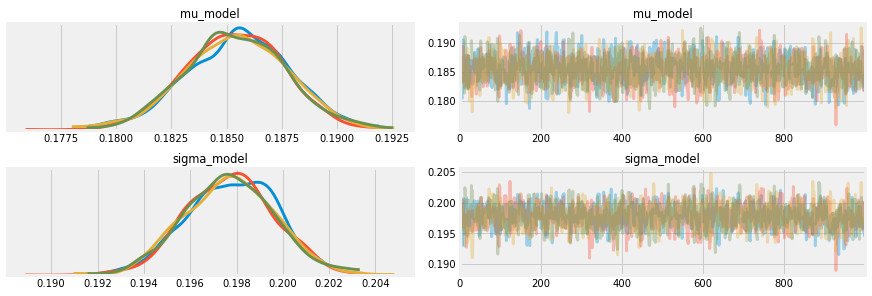

In [24]:
az.plot_trace(trace)

In [26]:
N = df_data.shape[0]
t = np.arange(0,N) #array of observation positions ('time')
with pm.Model() as model: # context management
    mu_model_1 = pm.Uniform('mu_model_1',0,1)
    sigma_model_1 = pm.Uniform('sigma_model_1',0,T.sqrt(mu_model_1*(1- mu_model_1)))
    
    mu_model_2 = pm.Uniform('mu_model_2',0,1)
    sigma_model_2 = pm.Uniform('sigma_model_2',0,T.sqrt(mu_model_2*(1- mu_model_2)))
    
    tau1 = pm.DiscreteUniform("tau1",t.min(),t.max())
    tau2 = pm.DiscreteUniform("tau2",tau1,t.max())
    
    #define stochastic variable mu
    _mu_model = T.switch(tau1>=t,mu_model_1,mu_model_2)
    mu_model = T.switch(tau2>=t ,_mu_model, mu_model_1)
    
    _mu_model = T.switch(tau1>=t,mu_model_1,mu_model_2)
    mu_model = T.switch(tau2>=t ,_mu_model, mu_model_1)
    
    _sigma_model = T.switch(tau1>=t,sigma_model_1,sigma_model_2)
    sigma_model = T.switch(tau2>=t ,_sigma_model, sigma_model_1)
    
    outage_prob = pm.Beta('outage_prob',mu = mu_model,sigma = sigma_model, observed = df_data.value)

In [32]:
with model:
  trace = pm.sample(1000,tune=4000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [sigma_model_2, mu_model_2, sigma_model_1, mu_model_1]
>CompoundStep
>>Metropolis: [tau2]
>>Metropolis: [tau1]
Sampling 4 chains, 0 divergences: 100%|██████████| 20000/20000 [01:09<00:00, 289.46draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [33]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
tau1,1997.982,0.143,1998.000,1998.000,0.006,0.004,623.0,623.0,644.0,4000.0,1.01
tau2,4999.035,0.206,4999.000,4999.000,0.008,0.006,653.0,653.0,648.0,651.0,1.01
mu_model_1,0.037,0.000,0.036,0.038,0.000,0.000,3121.0,3120.0,3128.0,3091.0,1.00
sigma_model_1,0.032,0.001,0.031,0.033,0.000,0.000,2996.0,2994.0,3002.0,2792.0,1.00
mu_model_2,0.384,0.004,0.377,0.391,0.000,0.000,4663.0,4660.0,4648.0,3453.0,1.00
sigma_model_2,0.205,0.002,0.201,0.209,0.000,0.000,3361.0,3357.0,3368.0,2834.0,1.00


In [34]:
tau_samples1 = trace['tau1']
tau_samples2 = trace['tau2']

count    4000.000000
mean     4999.034750
std         0.206284
min      4999.000000
25%      4999.000000
50%      4999.000000
75%      4999.000000
max      5001.000000
dtype: float64